In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
# to save and write as pngs
from imageio import imwrite, imread
import math
from scipy import ndimage as ndi

In [4]:
def plt_fig_hist(image):
    plt.figure(figsize=(12,12));
    plt.subplot(1, 2, 1);
    plt.imshow(image, cmap='gray');
    plt.xlabel('x');
    plt.ylabel('y');
    plt.subplot(1, 2, 2);
    uniqe = np.unique(image, return_counts=True);
    plt.plot(uniqe[0],uniqe[1]);
    plt.xlabel('values');
    plt.ylabel('counts');
    plt.show();
    
def print_info(image):
    unique = np.unique(image);
    print('The first 5 values in the image: \n', unique[0:5]);
    print('The maximum value is: {}, and minimum is: {}'.format(np.max(image), np.min(image)));
    print('The mean value is: {}, and the median is: {}'.format(np.mean(image), np.median(image)));
    print('Total Number of values in the image: ',len(unique));
    print('The image size: {}, dimensions: {} and the shape: {}'.format(image.size, image.ndim, image.shape));    
    
def give_transferMatrix(scaling):
    sx=scaling[0]
    sy=scaling[1]
    scale_matrix = [[sx, 0],
                [0, sy]]
    return scale_matrix

def build_weighMatrix(image, radius=None):
    if radius == None:
        radius = image.shape[0]/5;
    else:
        radius = radius;
        
    G = np.zeros((image.shape[0]**2,image.shape[1]**2));
    std_img = np.std(image);
    indices_dict = build_indices_dict(image);
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):            
            distance_diff = calc_node_distance(indices_dict[i], indices_dict[j]);
            if int(np.round(distance_diff)) < radius:
                distance_diff = np.exp(-distance_diff/(len(image)*0.1));
            else:
                distance_diff = 0;
            intens_diff = np.exp(-calc_nodes_intens_diff(image[indices_dict[i]], image[indices_dict[j]])/std_img)
            G[i,j] = intens_diff * distance_diff;
    return G;

def calc_node_distance(nodeA, nodeB):    
    dis_deff = np.sqrt(np.power(nodeA[0]-nodeB[0], 2) + np.power(nodeA[1]-nodeB[1], 2));
    return dis_deff;

def calc_nodes_intens_diff(intensityA, intensityB):
    intens_diff = np.sqrt(np.power(intensityA - intensityB, 2));
    return intens_diff;

def build_indices_dict(image):
    indices = dict()
    s = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            indices[s] = (i, j)
            s += 1
    return indices


In [5]:
# image = imread("testImagio_dicom.png");
im_obj = sitk.ReadImage('data/IMG-0002-00074.dcm');
im_array = sitk.GetArrayViewFromImage(im_obj)
im_array_squeezed = im_array.squeeze()
image = im_array_squeezed;

In [149]:
gdf = geopandas.GeoDataFrame(image);
gdf

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-997,-998,-1005,-1003,-1003,-1003,-1003,-1000,-996,-1006
1,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-998,-1009,-1007,-998,-1000,-1004,-1003,-1002,-1001,-1009
2,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-1006,-1004,-1000,-998,-999,-1006,-1003,-1002,-1005,-1000
3,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-1001,-994,-1007,-1007,-997,-1001,-999,-1003,-1006,-1002
4,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-994,-1009,-1015,-996,-991,-1000,-1006,-1009,-1003,-998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-981,-957,-884,-774,-585,-311,-86,-71,-306,-619
508,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-943,-874,-736,-556,-303,-83,-106,-350,-615,-801
509,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-831,-699,-480,-233,-61,-109,-385,-672,-846,-940
510,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,-1024,...,-659,-445,-192,-34,-113,-379,-674,-869,-966,-1010


In [52]:
print_info(image);

The first 5 values in the image: 
 [-1024 -1023 -1022 -1021 -1020]
The maximum value is: 1118, and minimum is: -1024
Total Number of values in the image:  1848
The image size: 262144, dimensions: 2 and the shape: (512, 512)


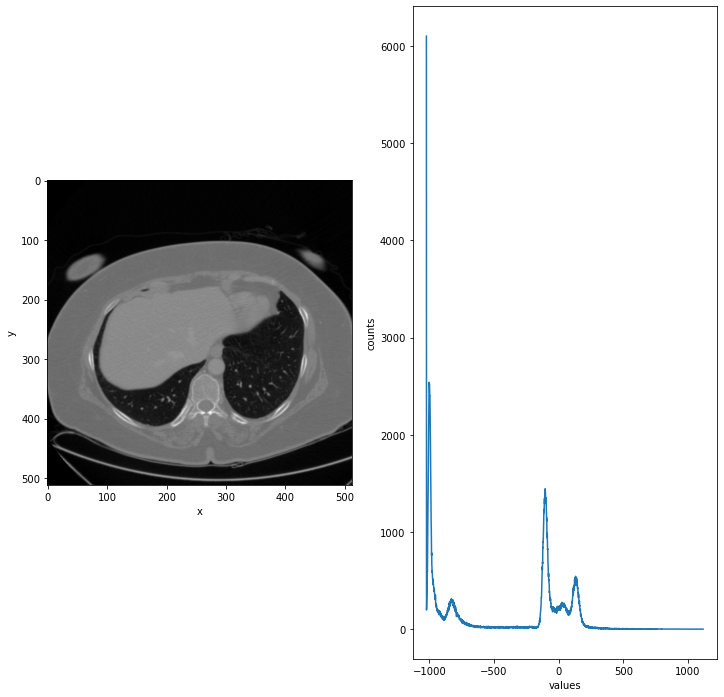

In [32]:
plt_fig_hist(image);

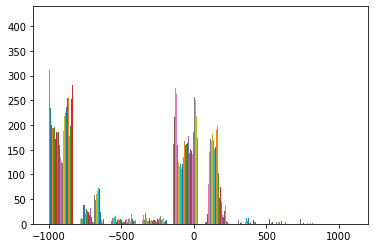

In [33]:
plt.hist(image)
plt.show()

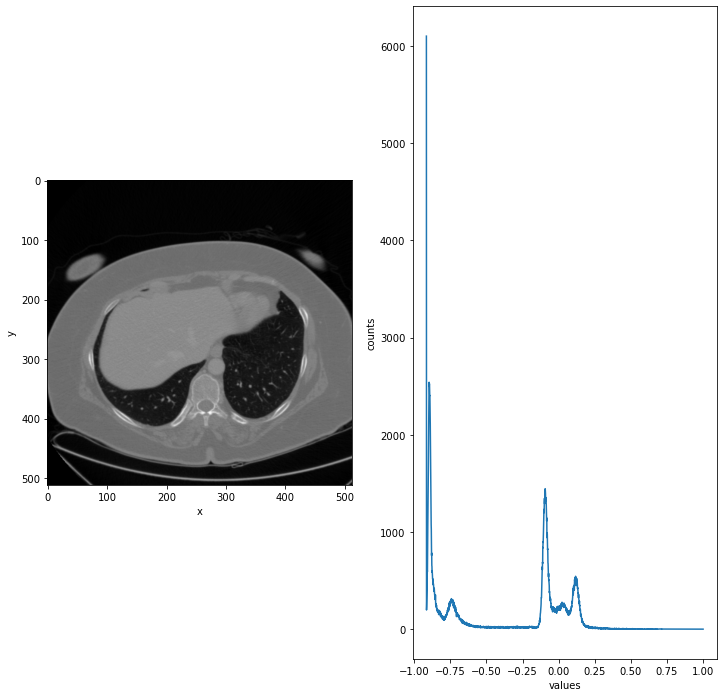

In [6]:
norm_img = image/np.max(image);
plt_fig_hist(norm_img);

In [58]:
print_info(norm_img)

The first 5 values in the image: 
 [-0.91592129 -0.91502683 -0.91413238 -0.91323792 -0.91234347]
The maximum value is: 1.0, and minimum is: -0.9159212880143113
Total Number of values in the image:  1848
The image size: 262144, dimensions: 2 and the shape: (512, 512)


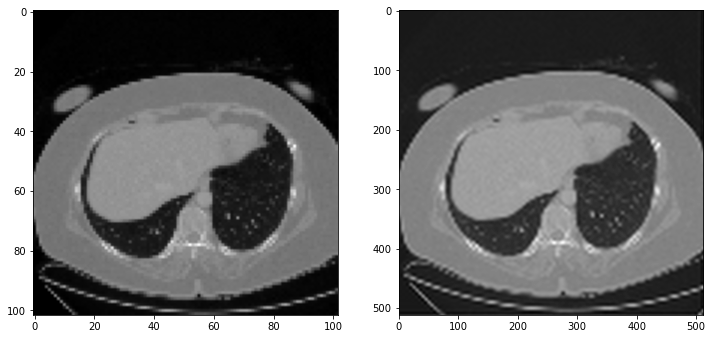

In [39]:
# test to go back to original size, loose resolution! maybe it's okey, we only need to obtain a segmentation mask to
# put on/merge with the original image!
# invers_scaling_factor = 1/scaling_factor;
# transf_matrix = give_transferMatrix([invers_scaling_factor , invers_scaling_factor]);

# # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.interpolation.affine_transform.html
# ssd_reg_img_test = ndi.interpolation.affine_transform(ssd_reg_img, transf_matrix, offset=(0, 0))

# plt.figure(figsize=(12,8))
# plt.subplot(1, 2, 1)
# plt.imshow(scaled_image, cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(ssd_reg_img_test, cmap='gray')
# plt.show()

In [7]:
# clipp values out of interest from original image 
test_clipping_img = np.array(image);
test_clipping_img.setflags(write=1); # allow clipping values
# test_clipping_img.flags
test_clipping_img[test_clipping_img < -160] = -1024; # the region of the liver, clipp the others!
test_clipping_img[test_clipping_img > 240] = -1024;

norm_test_clipping_img = np.sqrt((test_clipping_img+np.abs(np.min(test_clipping_img)))**2); # add an offset to 'remove' negative values
norm_test_clipping_img = norm_test_clipping_img/np.max(norm_test_clipping_img); # normalize


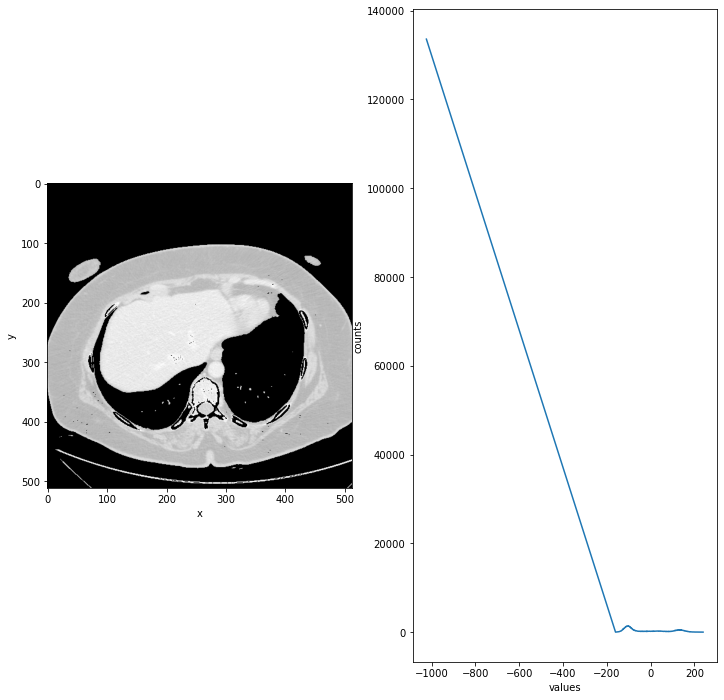

In [8]:
plt_fig_hist(test_clipping_img);

In [9]:
print_info(test_clipping_img)

The first 5 values in the image: 
 [-1024  -160  -159  -158  -157]
The maximum value is: 240, and minimum is: -1024
The mean value is: -528.4657135009766, and the median is: -1024.0
Total Number of values in the image:  402
The image size: 262144, dimensions: 2 and the shape: (512, 512)


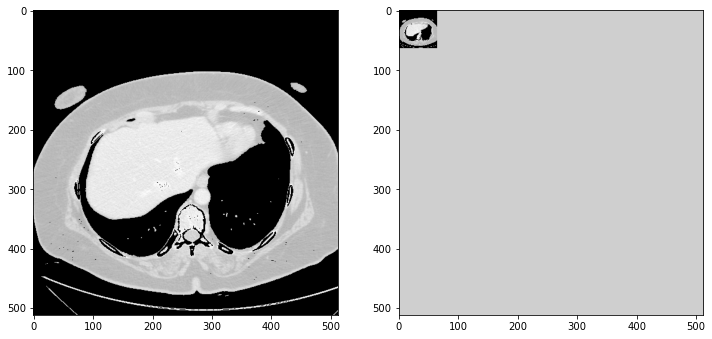

In [10]:
scaling_factor = 8;
transf_matrix = give_transferMatrix([scaling_factor, scaling_factor]);
ssd_regClipped_img = ndi.interpolation.affine_transform(test_clipping_img, transf_matrix, offset=(0, 0))

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(test_clipping_img, cmap='gray')
plt.subplot(122)
plt.imshow(ssd_regClipped_img, cmap='gray')
plt.show()

In [11]:
scaled_clipped_img = ssd_regClipped_img[0:int(round(image.shape[0]/scaling_factor)), 0:int(round(image.shape[1]/scaling_factor))];

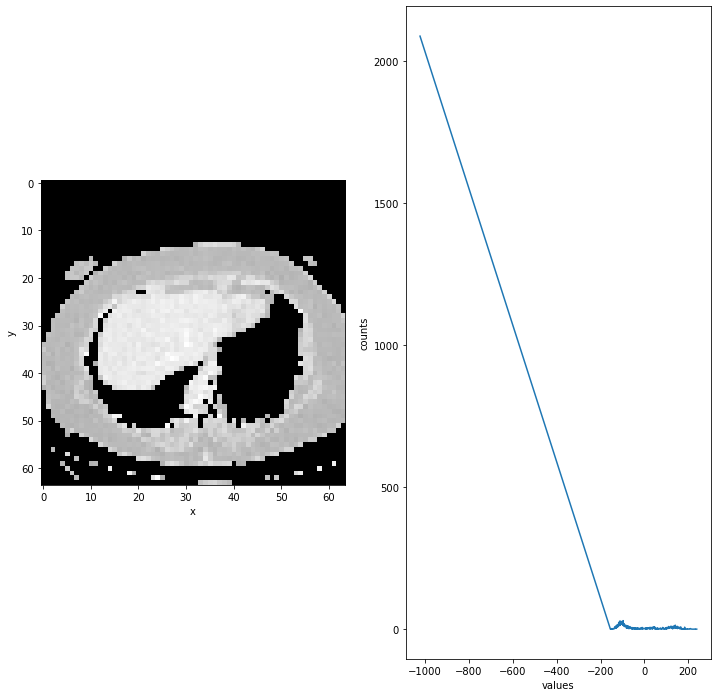

In [12]:
plt_fig_hist(scaled_clipped_img)

In [13]:
print_info(scaled_clipped_img)

The first 5 values in the image: 
 [-1024  -155  -154  -153  -151]
The maximum value is: 239, and minimum is: -1024
The mean value is: -528.6455078125, and the median is: -1024.0
Total Number of values in the image:  341
The image size: 4096, dimensions: 2 and the shape: (64, 64)


In [14]:
clipped_img_weight_matrix = build_weighMatrix(scaled_clipped_img, 5);

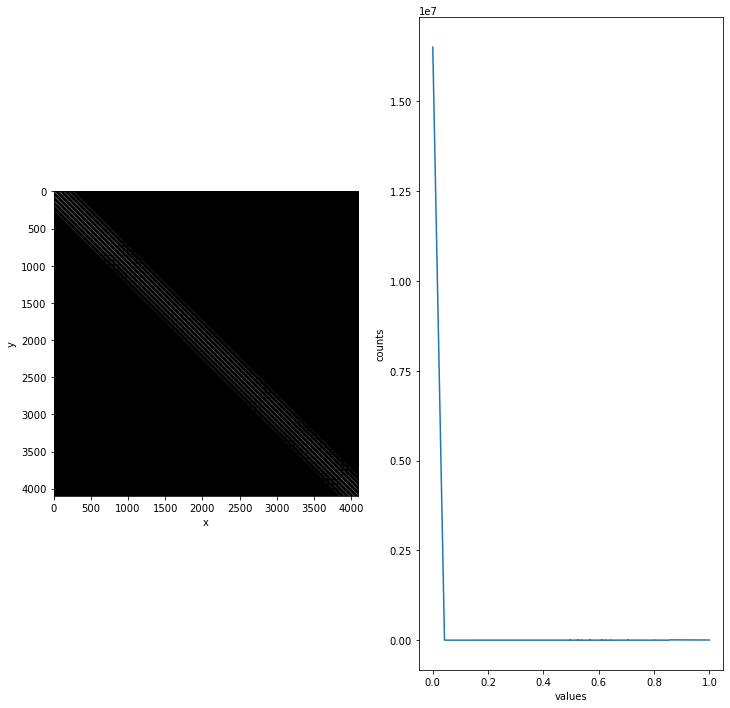

In [15]:
plt_fig_hist(clipped_img_weight_matrix);

In [16]:
print_info(clipped_img_weight_matrix);

The first 5 values in the image: 
 [0.         0.04204839 0.04229642 0.04237942 0.04246258]
The maximum value is: 1.0, and minimum is: 0.0
The mean value is: 0.00816788475580599, and the median is: 0.0
Total Number of values in the image:  6752
The image size: 16777216, dimensions: 2 and the shape: (4096, 4096)


In [82]:
# np.savetxt("Ahmad_simi_matrix.csv", g, fmt='%1.4f', delimiter=",")
# imwrite(str("Ahmad_simi_matrix.png"), g)
# i = imread("Ahmad_simi_matrix.png");
# i = i/np.max(i)

In [17]:
clipped_eig = np.linalg.eig(clipped_img_weight_matrix);
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

In [18]:
print(clipped_eig[1][:])

[[ 4.03441668e-03  2.10589022e-03  6.37976306e-05 ...  2.23092686e-02
   4.42941969e-02  1.12139791e-02]
 [ 5.71300296e-03  2.96673465e-03  8.90567629e-05 ... -5.65467189e-02
   2.01006705e-02  1.56422107e-02]
 [ 7.59904275e-03  3.92160907e-03  1.16428955e-04 ...  1.01303147e-02
  -2.72935768e-02 -1.03298088e-02]
 ...
 [ 4.16212486e-09 -2.10155245e-08 -2.50582888e-05 ... -2.13229544e-02
  -2.84888145e-02 -1.16237605e-02]
 [ 3.30536569e-09 -1.67877383e-08 -1.98548244e-05 ...  3.26096258e-02
   2.06626529e-02 -3.33577877e-02]
 [ 2.31666604e-09 -1.18380556e-08 -1.39053848e-05 ...  3.06116580e-02
  -1.42929071e-03  7.92225535e-03]]


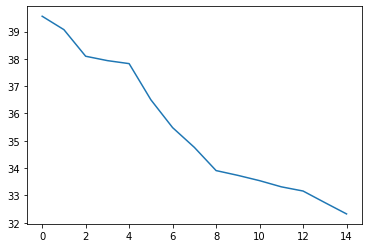

In [20]:
# print(np.max(clipped_eig[0]))
plt.plot(clipped_eig[0][0:15]) # first 15 eigen values


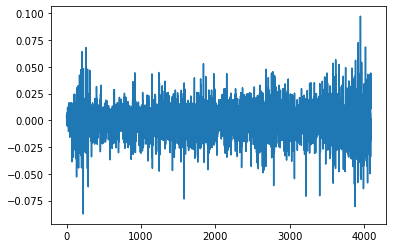

In [21]:
plt.plot(clipped_eig[1][0]); # plot first eigenVector

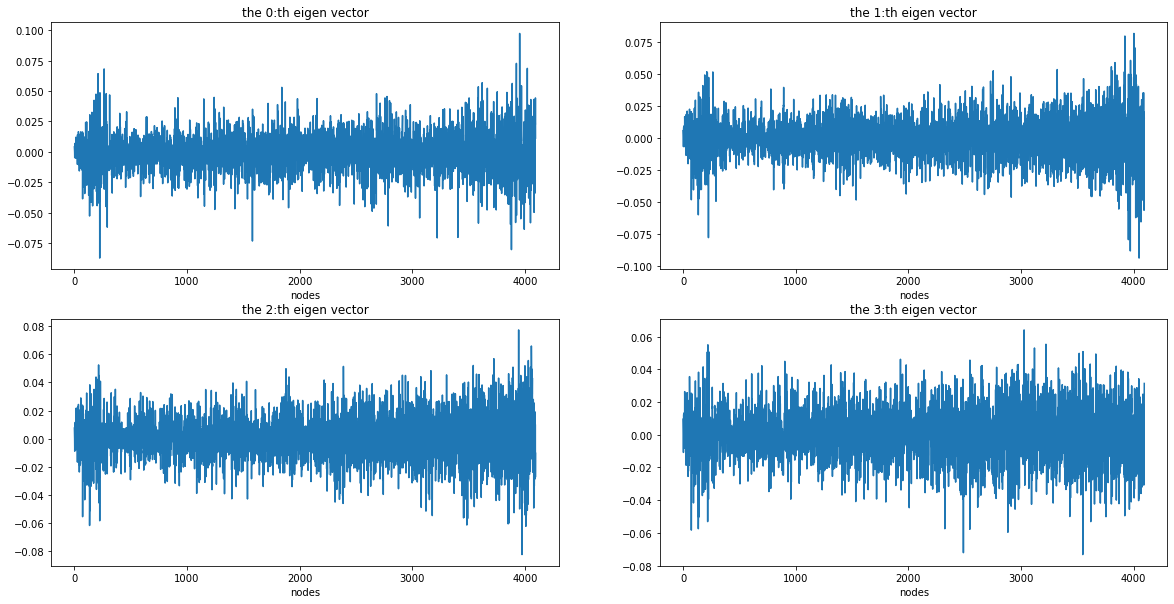

In [22]:
plt.figure(figsize=(20,10));
plt.subplot(2, 2, 1);
plt.plot(clipped_eig[1][0]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(0));
plt.subplot(2, 2, 2);
plt.plot(clipped_eig[1][1]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(1));
plt.subplot(2, 2, 3);
plt.plot(clipped_eig[1][2]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(2));
plt.subplot(2, 2, 4);
plt.plot(clipped_eig[1][3]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(3));
plt.show();

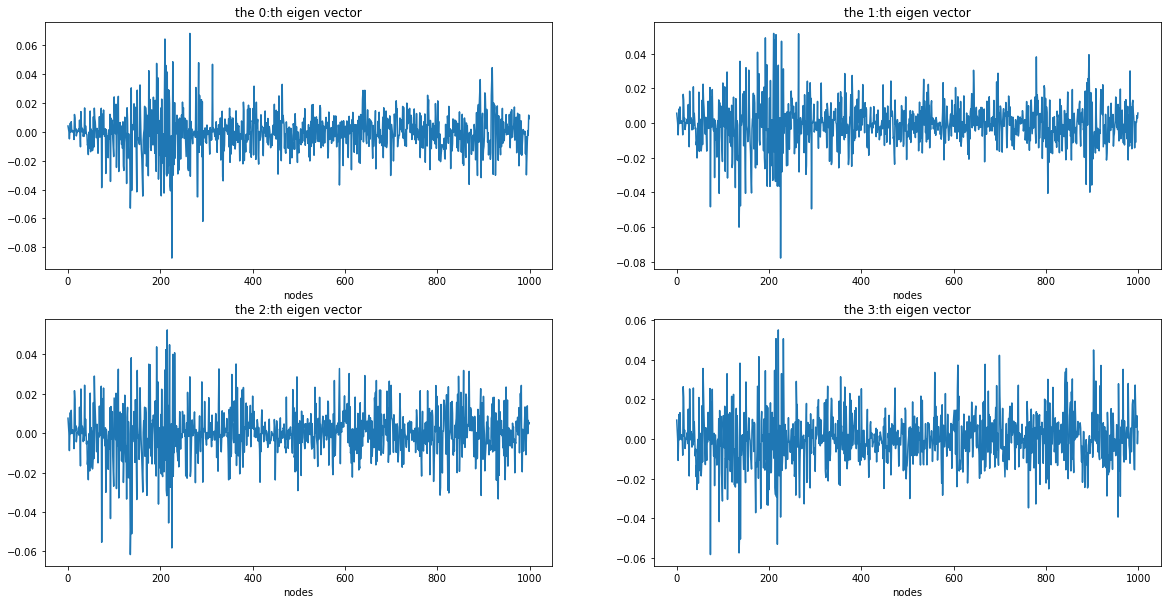

In [26]:
plt.figure(figsize=(20,10));
plt.subplot(2, 2, 1);
plt.plot(clipped_eig[1][0][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(0));
plt.subplot(2, 2, 2);
plt.plot(clipped_eig[1][1][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(1));
plt.subplot(2, 2, 3);
plt.plot(clipped_eig[1][2][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(2));
plt.subplot(2, 2, 4);
plt.plot(clipped_eig[1][3][0:1000]);
plt.xlabel('nodes');
plt.title('the {}:th eigen vector'.format(3));
plt.show();